# SV Data Challenge - BGS

The purpose of this notebook is to simulate DESI Survey Validation (SV) observations of a single GAMA field, as a test of the BGS component of SV.

A good set of reference files from the [end-to-end minitest](https://github.com/desihub/desitest/blob/master/mini/minitest.ipynb) notebook are located in */global/cscratch1/sd/sjbailey/desi/dev/end2end*.

In [2]:
import os, sys, glob, time, subprocess, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [3]:
from astropy.table import Table, hstack, Column
from astropy.io import fits
import fitsio

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Thu Jun  7 09:37:14 2018


### Set some environment variables and create output directories

Define and create directories under `$DESI_ROOT/survey-validation` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

In [6]:
basedir = os.path.join(os.getenv('DESI_ROOT'), 'survey-validation')
surveydir = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')

os.environ['DESISURVEY_OUTPUT'] = surveydir
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'sv-bgs'
os.environ['SPECPROD'] = 'sv-bgs'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

for dd in (surveydir, targetdir, fibassigndir, reduxdir, simdatadir):
    os.makedirs(dd, exist_ok=True)

In [7]:
samplefile = os.path.join(basedir, 'sv-bgs-sample.fits')
tilesfile = os.path.join(os.getenv('DESIMODEL'), 'data', 'footprint', 'sv-bgs-tiles.fits')
surveyconfigfile = os.path.join(basedir, 'sv-bgs-survey-config.yaml')
expfile = os.path.join(surveydir, 'exposures.fits')

In [8]:
seed = 1

In [9]:
overwrite_sample = True
overwrite_tiles = True
overwrite_surveysim = True

### Define and visualize the GAMA/BGS sample.

Here we select a magnitude-limited (BGS-like) sample of GAMA targets in the G02 field with high-quality redshifts and Legacy Surveys photometry.

In [10]:
def read_legacysurvey_gama(faintcut=20, overwrite=False):
    """Read the GAMA/DR3 catalog and select the G02 field.
    
    """
    truthdir = os.path.join(os.getenv('DESI_ROOT'), 'target', 'analysis', 'truth')
    
    def select_G02(cat, phot=None, return_index=False, faintcut=20):
        """Select the G02 field where it is complete.
        See Table 1 in https://arxiv.org/pdf/1506.08222.pdf
        """
        cut = ( (cat['RA'] > 30) * (cat['RA'] < 39) * 
                (cat['DEC'] >= -6) * (cat['DEC'] <= -4)
              )
        if phot:
            cut = ( cut * (cat['NQ'] >= 3) * #(cat['Z'] < 1) * 
                    (phot['FLUX_R'] > 10**((22.5 - faintcut) / 2.5)) 
                  )
            print('Selecting {} objects in the G02 field with NQ>=3 and r<{:.1f}.'.format(
                np.sum(cut), faintcut))
        else:
            print('Selecting {} objects in the G02 field.'.format(np.sum(cut)))
        
        outcat = cat[cut]
        if return_index:
            return cut
        else:
            return outcat
    
    def read_all_gama():
        """Read all the objects in GAMA/DR3."""
        gamafile = os.path.join(truthdir, 'parent', 'GAMA-DR3-SpecObj.fits')
        allgama = Table.read(gamafile)
        print('Read {} objects from {}'.format(len(allgama), gamafile))
        gama = select_G02(allgama)
        return allgama, gama

    def read_legacysurvey(faintcut=20):
        """Read the GAMA/DR3 catalog matched to LegacySurvey/DR5."""
        gamafile = os.path.join(truthdir, 'dr5.0', 'trimmed', 'GAMA-DR3-SpecObj-trim.fits')
        alllsgama = Table.read(gamafile)
        print('Read {} objects from {}'.format(len(alllsgama), gamafile))
        
        lsfile = os.path.join(truthdir, 'dr5.0', 'trimmed', 'decals-dr5.0-GAMA-DR3-SpecObj-trim.fits')
        allls = Table.read(lsfile)
        print('Read {} objects from {}'.format(len(allls), lsfile))
        
        # Trim to the G02 field and join the two catalogs.
        indx = select_G02(alllsgama, phot=allls, return_index=True, faintcut=faintcut)
        lsgama = hstack( (allls[indx], alllsgama[indx]) )
        lsgama.rename_column('RA_1', 'RA')
        lsgama.rename_column('DEC_1', 'DEC')
        lsgama.rename_column('RA_2', 'RA_GAMA')
        lsgama.rename_column('DEC_2', 'DEC_GAMA')
        
        return lsgama
        
    def get_rmag(cat):
        return 22.5 - 2.5 * np.log10(cat['FLUX_R'] / cat['MW_TRANSMISSION_R'])
        
    allgama, gama = read_all_gama()
    lsgama = read_legacysurvey(faintcut=faintcut)
    
    if overwrite:
        print('Writing {} GAMA/BGS targets to {}'.format(len(lsgama), samplefile))
        lsgama.write(samplefile, overwrite=overwrite)
    
    allgama_G02 = allgama[(allgama['RA'] > 30) * (allgama['RA'] < 39)]
    
    # Visualize the position of the G02 field.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.scatter(allgama['RA'], allgama['DEC'], s=1)
    ax1.set_title('All GAMA Fields (N={})'.format(len(allgama)))
    
    ax2.scatter(allgama_G02['RA'], allgama_G02['DEC'], s=1, label='All Objects (N={})'.format(len(allgama_G02)))
    ax2.scatter(gama['RA'], gama['DEC'], s=1, label='Complete Region (N={})'.format(len(gama)))
    ax2.set_xlim(29, 40)
    ax2.set_ylim(-11, -2)
    ax2.set_title('GAMA/G02 Field')
    ax2.legend(loc='upper left', ncol=1, markerscale=5)
    
    ax3.scatter(lsgama['RA'], lsgama['DEC'], s=1, alpha=0.5, 
                label='NQ>=3, r<{:.1f} (N={})'.format(faintcut, len(lsgama)))
    ax3.set_xlim(29, 40)
    ax3.set_ylim(-7, -3)
    ax3.set_title('GAMA/G02 Field')
    ax3.legend(loc='upper left', markerscale=5)

    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        
    fig.subplots_adjust(wspace=0.25)
    if overwrite:
        fig.savefig(os.path.join(basedir, 'qa-sv-bgs-all.png'))
    
    # Visualize the magnitude and redshift distributions.
    rmag = get_rmag(lsgama)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.hist(lsgama['Z'], bins=50)
    ax1.set_xlabel('GAMA Redshift')
    ax1.set_ylabel('Number of Objects')
    
    ax2.hist(rmag, bins=60)
    ax2.set_xlabel(r'$r_{cor}$ (DECaLS, AB mag)')
    ax2.set_ylabel('Number of Objects')
    ax2.axvline(x=faintcut, color='k', ls='--')
    
    ax3.scatter(lsgama['Z'], rmag, s=1)
    ax3.set_xlabel('GAMA Redshift')
    ax3.set_ylabel(r'$r_{cor}$ (DECaLS, AB mag)')
    ax3.set_ylim(12, 20)
    ax3.axhline(y=faintcut, color='k', ls='--')
    
    fig.subplots_adjust(wspace=0.25)
    if overwrite:
        fig.savefig(os.path.join(basedir, 'qa-sv-bgs.png'))
    
    return lsgama

Read 160026 objects from /Users/ioannis/work/desi/target/analysis/truth/parent/GAMA-DR3-SpecObj.fits
Selecting 19695 objects in the G02 field.
Read 157343 objects from /Users/ioannis/work/desi/target/analysis/truth/dr5.0/trimmed/GAMA-DR3-SpecObj-trim.fits
Read 157343 objects from /Users/ioannis/work/desi/target/analysis/truth/dr5.0/trimmed/decals-dr5.0-GAMA-DR3-SpecObj-trim.fits
Selecting 16010 objects in the G02 field with NQ>=3 and r<19.7.
Writing 16010 GAMA/BGS targets to /Users/ioannis/work/desi/survey-validation/sv-bgs-sample.fits


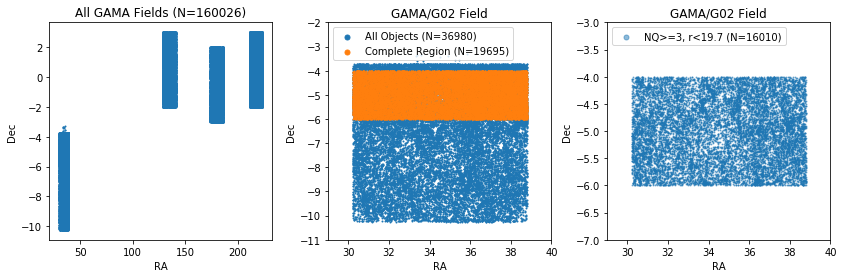

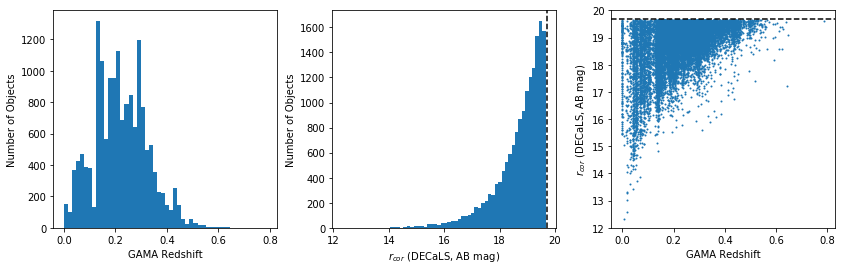

In [11]:
gama = read_legacysurvey_gama(faintcut=19.7, overwrite=overwrite_sample)

In [12]:
gama[:2]

RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92
5000,295990,0347m060,3740,COMP,34.890341079425994,-5.999691682110999,4570791000000.0,4816965000000.0,380718.56 .. 657301.0,0.025039164,0.0,14.195835,40.030807,0.0,77.26228,0.0,74.38492,53.769085,145.09949,17.496735,0.0,575.5074,173.69781,0.0,44.052402,0.0,1.4482807,0.3196188,0.0014982224,3.4697245e-05,0.9119844,0.9285593,0.9512969,0.96395123,0.97245836,0.9757607,0.99576557,0.9973974,0.99944437,0.99979013,0,8,9,0,10,0,83,84,24,24,0.0,2.906153,1.3095417,0.0,1.7787125,0.0,2.4887478,0.7378041,0.5677778,0.103369206,0.0,5.6221965e-05,7.64634e-05,0.0,1.7972214e-05,0.0,0.02481547,0.026488105,0.2887721,21.924564,0.0,0.0050085993,0.0035609463,0.0,0.061266117,0.0,0.0,1.0148772,1.0301899,0.0,0.9659238,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1.4427451,1.3211417,0.0,1.0914309,0.0,0.0,4988.781,1655.8958,0.0,459.8917,0.0,0.0,3043.762,969.0382,0.0,234.25917,0.0,0349m061,0.13350707,2120865.2,0.32979923,36816.79,-0.07739693,2620.0586,-0.6948547,1137.4686,1.9406624,100692.01,0.018664878,267119.28,0.075529814,579053.75,1075400,GAMAJ021933.67-055958.8,8192,1,1,0.0,G02_Y3_018_362,GAMA,5,34.89033,-5.99968,3727.0,8858.05,0.25562,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_018_362.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_018_362.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/pn

### Tile the GAMA/G02 BGS field

Here we produce an overly simplistic three-tile (three-pointing) solution. This code and the corresponding output files should go into *desimodel.footprint*.

From Eddie:

The tilesra2s, tilesdec2s scheme below is also pretty good for filling in the holes in the DESI focal plane with 3 dithers, so any hexagonal-close-packed scheme with ~1.6 degree spacing and that dither pattern should be pretty good.

I can recommend
```
tilesra2b, tilesdec2b = tiling.simpleradecoffscheme(desitiles['ra'][m0], desitiles['dec'][m0], dx=1.4, ang=330)
tilesra2s, tilesdec2s = tiling.simpleradecoffscheme(desitiles['ra'][m0], desitiles['dec'][m0], dx=0.6, ang=42)
```
as providing a simple set of dithers that fill in almost all of the DESI focal plane holes at 3 dithers, given the DESI PASS 1 tiles as a base, though any ~hexagonal scheme with equal density of points to the DESI tiles PASS 1 polyhedron will work equally well.  These are just uniform offsets in ra and dec.


In [13]:
def simpleradecoffscheme(ras, decs, dx=0.6, ang=42):
    # take a single covering, define 4 sets of offsets, 
    # start with something minimal: need to cover:
    # central bulls-eyes: 0.2 deg
    # GFA gaps: up to 0.4 deg
    
    # okay: 
    from numpy import sin, cos
    ang = numpy.radians(ang)
    dang = numpy.pi/2
    dithers = [[0, 0], 
               [dx*sin(ang+0*dang), dx*cos(ang+0*dang)], 
               [dx*sin(ang+1*dang), dx*cos(ang+1*dang)],
               [dx*sin(ang+2*dang), dx*cos(ang+2*dang)]]
    dithers = numpy.cumsum(numpy.array(dithers), axis=0)
    dithers = list(dithers) + [[numpy.mean([d[0] for d in dithers]),
                                numpy.mean([d[1] for d in dithers])]]
    fac = 1./numpy.cos(numpy.radians(decs))
    fac = numpy.clip(fac, 1, 360*5)  # confusion near celestial pole.
    newras = numpy.concatenate([ras+d[0]*fac for d in dithers])
    newdecs = numpy.concatenate([decs+d[1] for d in dithers])
    newdecs = numpy.clip(newdecs, -numpy.inf, 90.)
    newras = newras % 360
    newras = numpy.concatenate([newras, newras])
    newdecs = numpy.concatenate([newdecs, newdecs])
    return newras, newdecs

In [14]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color, alpha=0.5)

In [15]:
def qa_tiles(cat):
    fig, ax = plt.subplots()
    ax.scatter(cat['RA'], cat['DEC'], s=1, alpha=0.5)
    for tt in tiles:
        plot_tile(tt['RA'], tt['DEC'])
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

In [16]:
def gama_bgs_footprint(overwrite=False):
    """The tiling solution needs to be done properly and the code 
    needs to be moved elsewhere.
    
    """
    ntile = 3
    tiles = Table()
    tiles.add_column(Column(name='TILEID', dtype=np.int32, length=ntile))
    tiles.add_column(Column(name='RA', dtype='f8', length=ntile))
    tiles.add_column(Column(name='DEC', dtype='f8', length=ntile))
    tiles.add_column(Column(name='PASS', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='IN_DESI', dtype=np.int16, length=ntile))
    tiles.add_column(Column(name='EBV_MED', dtype='f4', length=ntile))
    tiles.add_column(Column(name='AIRMASS', dtype='f4', length=ntile))
    tiles.add_column(Column(name='STAR_DENSITY', dtype='f4', length=ntile))
    tiles.add_column(Column(name='EXPOSEFAC', dtype='f4', length=ntile))
    tiles.add_column(Column(name='PROGRAM', dtype='S4', length=ntile))
    tiles.add_column(Column(name='OBSCONDITIONS', dtype=np.int32, length=ntile))
    
    tiles['RA'] = [31.5, 34.3, 37.1]
    tiles['DEC'] = [-4.8, -5.2, -5.0]
    tiles['TILEID'] = [100000, 100001, 100002]
    tiles['PASS'] = 1
    tiles['AIRMASS'] = 1.0
    tiles['IN_DESI'] = 1 # assume all "in DESI"
    tiles['EXPOSEFAC'] = 1.0
    tiles['PROGRAM'] = 'DARK'
    tiles['OBSCONDITIONS'] = 1
    
    if overwrite:
        print('Writing {}'.format(tilesfile))
        tiles.write(tilesfile, overwrite=overwrite)
    
    return tiles

In [17]:
tiles = gama_bgs_footprint(overwrite=overwrite_tiles)
tiles

Writing /Users/ioannis/repos/desihub/desimodel/data/footprint/sv-bgs-tiles.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int64,float64,float64,int16,int16,float32,float32,float32,float32,bytes4,int32
100000,31.5,-4.8,1,1,0.0,1.0,0.0,1.0,DARK,1
100001,34.3,-5.2,1,1,0.0,1.0,0.0,1.0,DARK,1
100002,37.1,-5.0,1,1,0.0,1.0,0.0,1.0,DARK,1


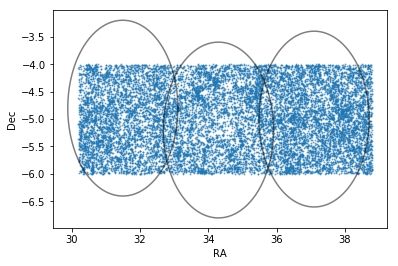

In [18]:
qa_tiles(gama)

### Run survey simulations

Simulate SV observing.

One outstanding question is whether we need a new set of rules when calling *surveyplan* other than those in [desisurvey/data](https://github.com/desihub/desisurvey/tree/master/py/desisurvey/data).

Note that we convert *progress.fits*, which is one row per tile, to *exposures.fits*, which has one row per exposure.

In [19]:
def survey_simulations(overwrite=False):
    """Run survey simulations.
    
    """
    if overwrite or not os.path.isfile(expfile):
        from desisurvey.progress import Progress
        from desisurvey.config import Configuration
        from surveysim.util import add_calibration_exposures
    
        Configuration.reset()
        config = Configuration(surveyconfigfile)

        survey_logname = os.path.join(surveydir, 'survey.log')
        print('Running survey simulations; logging to {}'.format(survey_logname))
        
        with open(survey_logname, 'w') as logfile:
            cmd = "surveyinit --config-file {} --output-path {}".format(surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Use 0d fiber assignment delay to move on with mini sim quickly
            # Do we need new rules?!?
            cmd = "surveyplan --config-file {} --output-path {} --create --fa-delay 0d".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            cmd = "surveysim --config-file {} --output-path {} --seed {}".format(
                surveyconfigfile, surveydir, seed)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Do we need new rules?!?
            plan_cmd = 'surveyplan --config-file {} --output-path {} --fa-delay 0d'.format(
                surveyconfigfile, surveydir)
            sim_cmd = 'surveysim --resume --config-file {} --output-path {} --seed {}'.format(
                surveyconfigfile, surveydir, seed)
            while True:
                lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
                progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
                ndone = np.count_nonzero(progress['status'] == 2)
                print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
                if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break
                if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break

        # Make sure observing truly finished.
        progressfile = os.path.join(surveydir, 'progress.fits')
        if not os.path.exists(progressfile):
            print("ERROR: Missing {}".format(progressfile))
            print("Check {} for what might have gone wrong".format(survey_logname))
    
        print('Files in {}:\n'.format(surveydir))
        !ls $surveydir
        
        # convert progress.fits -> exposures.fits
        p = Progress(restore='progress.fits')
        explist = p.get_exposures()
        explist = add_calibration_exposures(explist)

        # Sanity check that all tiles in the subset were observed in the exposures list.
        if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
            print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
            print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
        else:
            print('All tiles in the subset were observed at least once.')
            explist.write(expfile, overwrite=True)
            print('Writing {}'.format(expfile))                

        # Optionally make a movie
        if False:
            cmd = "surveymovie --config-file {} --output-path {}".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0
    else:
        print('Simulated observing has been done.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [20]:
%time explist = survey_simulations(overwrite=overwrite_surveysim)

Running survey simulations; logging to /Users/ioannis/work/desi/survey-validation/survey/survey.log
Starting 2019-09-02 with 0/3 tiles completed Thu Jun  7 09:37:25 2018
Starting 2019-09-03 with 3/3 tiles completed Thu Jun  7 09:37:32 2018
Files in /Users/ioannis/work/desi/survey-validation/survey:

ephem_2019-09-01_2019-11-30.fits stats.fits
exposures.fits                   survey.log
last_date.txt                    surveyinit.fits
plan.fits                        surveymovie.mp4
progress.fits                    weather_1.fits
scheduler.fits
INFO:progress.py:145:__init__: Loaded progress from /Users/ioannis/work/desi/survey-validation/survey/progress.fits.
All tiles in the subset were observed at least once.
Writing /Users/ioannis/work/desi/survey-validation/survey/exposures.fits
CPU times: user 458 ms, sys: 121 ms, total: 579 ms
Wall time: 15.5 s


In [21]:
explist

EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int32,int64,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str4,str7
0,-1,-1,0.0,0.0,0.0,20190902,58729.30684,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,arc
1,-1,-1,0.0,0.0,0.0,20190902,58729.30730,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,arc
2,-1,-1,0.0,0.0,0.0,20190902,58729.30777,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,arc
3,-1,-1,0.0,0.0,0.0,20190902,58729.30823,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,flat
4,-1,-1,0.0,0.0,0.0,20190902,58729.30869,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,flat
5,-1,-1,0.0,0.0,0.0,20190902,58729.30916,10.0,0.0,0.0,0.0,0.000,0.0,0.0,CALI,flat
6,100000,1,31.5,-4.8,0.0,20190902,58729.30962,1339.0,0.9,1.0,2.0,0.208,-37.0,166.1,DARK,science
7,100000,1,31.5,-4.8,0.0,20190902,58729.32651,1081.5,0.9,1.0,2.0,0.208,-37.0,166.1,DARK,science


### Visualize which healpixels cover the observed tiles.

In [22]:
def tiles2pixels(nside=64):
    import desimodel.footprint
    pixels = desimodel.footprint.tiles2pix(nside, tiles)
    nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(
        len(tiles), nexp, len(pixels), nside))
    return pixels

In [23]:
def plot_healpix(nside, pixels, ax=None):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    if ax is None:
        fig, ax = plt.subplots()
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        ax.plot(ra, dec, '-', color='0.6') 

In [24]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray = explist['PROGRAM'] == 'GRAY'
    isdark = explist['PROGRAM'] == 'DARK'
    
    fig, ax = plt.subplots()
    ax.plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=10, mew=2, label='bright')
    ax.legend(loc='upper right')
    #ax.set_xlim(148, 157)
    #ax.set_ylim(28, 37)

In [25]:
def qa_tiles2pixels(nside=64):
    
    pixels = tiles2pixels(nside=nside)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    ax1.plot(tiles['RA'], tiles['DEC'], 'rx')
    ax1.plot(explist['RA'], explist['DEC'], 'b.', alpha=0.5)
    #xlim(0,360); ylim(-20, 80)

    plot_healpix(nside, pixels, ax=ax2)
    color = dict(DARK='k', GRAY='b', BRIGHT='m')
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = tiles['PROGRAM'] == program
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
        jj = tiles['PROGRAM'] == program
        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program])
    #xlim(143, 161); ylim(28, 37)
    
    return pixels

3 tiles covered by 6 exposures and 48 nside=64 healpixels


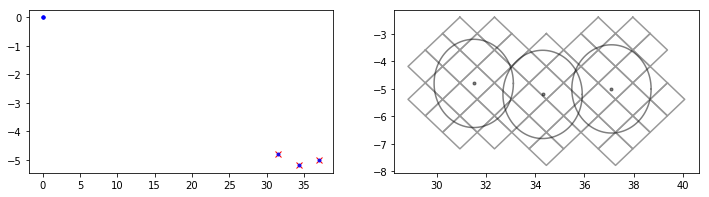

In [26]:
pixels = qa_tiles2pixels()

In [27]:
pixels

array([17670, 17671, 17675, 17676, 17677, 17678, 17679, 17680, 17681,
       17682, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690,
       17691, 17692, 17693, 17694, 17695, 17696, 17697, 17698, 17699,
       17700, 17701, 17702, 17703, 17704, 17705, 17707, 17708, 17709,
       17710, 17711, 17712, 17713, 17714, 17720, 17730, 17736, 36794,
       36795, 36798, 36799])

### Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [28]:
stop

NameError: name 'stop' is not defined

In [ ]:
def is_select_mock_targets_done(targetdir, pixels, verbose=False):
    done = True
    for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))
        if len(filenames) != len(pixels):
            done = False
    return done

In [ ]:
if is_select_mock_targets_done(targetdir, pixels):
    print("mpi_select_mock_targets already successfully run; skipping")
else:
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    tilefile = os.path.join(targetdir, 'test-tiles.fits')
    print('Running mpi_select_mock_targets batch job; this should take ~15 minutes.')
    print("Starting at {}".format(time.asctime()))
    print('Logging to {}'.format(logfilename))

    # configfile = os.path.join(os.getenv('DESITARGET'), 'doc', 'mock_example', 'input.yaml')
    configfile = './select-mock-targets.yaml'
    assert os.path.exists(configfile)
    
    cmd = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:30:00 --qos interactive"
    cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
    cmd += " --seed {} --nproc 16 --nside 64 --tiles {tilefile}".format(seed)
    cmd = cmd.format(targetdir=targetdir, tilefile=tilefile, configfile=configfile)
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('mpi_select_mock_targets failed err={}; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [ ]:
if is_select_mock_targets_done(targetdir, pixels, verbose=True):
    print('Success')
else:
    print('ERROR: missing files')
    print('Check {}'.format(logfilename))

## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [ ]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
err = subprocess.call(cmd.split())
if err != 0:
    print('join_mock_targets failed err={}'.format(err))
else:
    print('success')

### Do some sanity checks on the results

In [ ]:
targets = fitsio.read(os.path.join(targetdir, 'targets.fits'))
truth   = fitsio.read(os.path.join(targetdir, 'truth.fits'))
mtl     = fitsio.read(os.path.join(targetdir, 'mtl.fits'))
std     = fitsio.read(os.path.join(targetdir, 'standards-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

In [ ]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


In [ ]:
figure(figsize=(6,4))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run target selection QA

In [ ]:
targetfile = os.path.join(targetdir, 'targets.fits')
targetQAdir = os.path.join(targetdir, 'qa')
targetQAlog = os.path.join(targetQAdir, 'target-qa.log')
os.makedirs(targetQAdir, exist_ok=True)

cmd = 'run_target_qa {} {} --mocks --nside 32'.format(targetfile, targetQAdir)
with open(targetQAlog, 'w') as logfile:
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)

if err != 0:
    print('ERROR running {}'.format(cmd))
    msg = 'see {}'.format(targetQAlog)
    raise RuntimeError(msg)

In [ ]:
from IPython.display import Image, display
Image(targetQAdir+'/skymap-ALL.png', width=400)

## Run fiberassign

In [ ]:
def is_fiberassign_done(fibassigndir, tiles, verbose=False):
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'tile_{:05d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

# is_fiberassign_done(fibassigndir, tiles)

In [ ]:
if is_fiberassign_done(fibassigndir, tiles):
    print('fiberassign already done; skipping')
else:
    print('Generating lists of dark and bright tiles')
    #- Write list of tiles to consider
    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'BRIGHT':
            bx.write(str(tileid)+'\n')
        else:
            dx.write(str(tileid)+'\n')

    dx.close()
    bx.close()

    #- Remove any leftover tile files
    for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
        os.remove(tilefile)

    cmd = "fiberassign "
    cmd += " --mtl {}/mtl.fits".format(targetdir)
    cmd += " --stdstar {}/{{stdfile}}".format(targetdir)
    cmd += " --sky {}/sky.fits".format(targetdir)
    cmd += " --surveytiles {}/{{tilefile}}".format(fibassigndir)
    cmd += " --footprint {}/data/footprint/desi-tiles.fits".format(os.getenv('DESIMODEL'))
    cmd += " --positioners {}/data/focalplane/fiberpos.txt".format(os.getenv('DESIMODEL'))
    cmd += " --fibstatusfile {}/fiberstatus.ecsv".format(minitestdir)
    cmd += " --outdir {}".format(fibassigndir)

    #- Run fiberassign
    logfilename = os.path.join(fibassigndir, 'fiberassign.log')
    print('logging to {}'.format(logfilename))
    with open(logfilename, 'a') as logfile:
        for program in ['dark', 'bright']:
            stdfile = 'standards-{}.fits'.format(program)
            tilefile = '{}-tiles.txt'.format(program)
            cmdx = cmd.format(stdfile=stdfile, tilefile=tilefile)
            print('RUNNING', cmdx)
            err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('fiberassign failed err={}; see {}'.format(err, logfilename))
        
    #- Run fiberassign
#     logfilename = os.path.join(fibassigndir, 'fiberassign.log')
#     print('Running fiberassign; logging to {}'.format(logfilename))
#     with open(logfilename, 'a') as logfile:
#         cmd = "fiberassign {}/fiberassign-config-dark.txt".format(fibassigndir)
#         err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
#         if err != 0:
#             print('fiberassign failed err={}; see {}'.format(err, logfilename))

#         cmd = "fiberassign {}/fiberassign-config-bright.txt".format(fibassigndir)
#         err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
#         if err != 0:
#             print('fiberassign failed err={}; see {}'.format(err, logfilename))

    if is_fiberassign_done(fibassigndir, tiles, verbose=True):
        print('SUCCESS')
    else:
        print('ERROR: missing fiberassign output files')

#### Run fiberassign QA ####
This will find non-fatal errors with unassigned fibers and too few standards

In [ ]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

4.4 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes.

In [ ]:
def is_newexp_done(explist, simdatadir, verbose=False):
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(simdatadir+'/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir+'/*/fibermap*.fits')
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

# is_newexp_done(explist, simdatadir, verbose=True)

In [ ]:
if is_newexp_done(explist, simdatadir):
    print('newexp already done; skipping')
else:
    logfilename = os.path.join(simdatadir, 'newexp.log')
    tilefile = os.path.join(targetdir, 'test-tiles.fits')

    print('Running wrap-newexp batch job; should take ~5 min')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
    cmd += " -C haswell -t 00:15:00 --qos interactive"
    cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
    cmd += " --mockdir {}".format(targetdir)
    cmd += " --obslist {}/exposures.fits".format(surveydir)
    cmd += " --tilefile {}".format(tilefile)
    # print(cmd)
    
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-newexp; see {}'.format(err, logfilename))
        else:
            print('done')


### Confirm that we got the expected newexp output files

In [ ]:
if is_newexp_done(explist, simdatadir, verbose=True):
    print('Success')
else:
    print('ERROR: Missing files')

## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes

In [ ]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

# is_fastframe_done(explist, reduxdir, verbose=True)

In [ ]:
if is_fastframe_done(explist, reduxdir, verbose=True):
    print('fastframe already done; skipping')
else:
    logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
    os.makedirs(os.path.dirname(logfilename), exist_ok=True)
    print('Running fastframe batch job; should take ~7 min')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:20:00 --qos interactive".format(nodes=nodes)
    cmd += " wrap-fastframe --mpi"
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
        else:
            print('done at {}'.format(time.asctime()))

if is_fastframe_done(explist, reduxdir, verbose=True):
    print('SUCCESS')
else:
    print('ERROR; see {}'.format(logfilename))

In [ ]:
#- Check individual framefile outputs
ntot = 0
nbad = 0
for night, expid, flavor in explist['NIGHT', 'EXPID', 'FLAVOR']:
    if flavor != 'flat' and flavor != 'science':
        continue

    for channel in ['b', 'r', 'z']:
        for spectrograph in range(10):
            camera = channel + str(spectrograph)
            framefile = desispec.io.findfile('frame', night, expid, camera)
            ntot += 1
            if not os.path.exists(framefile):
                nbad += 1
                print('Missing {} frame {}'.format(flavor, framefile))

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))
else:
    print('All {} science and flat frame files generated'.format(ntot))

## Run the spectro pipeline

### First, create the production database.

In [ ]:
pipedbfile = desispec.io.get_pipe_database()
if not os.path.exists(pipedbfile):
    cmd = "desi_pipe create --db-sqlite --force"
    cmd += " --data {}".format(os.getenv('DESI_SPECTRO_DATA'))
    cmd += " --redux {}".format(os.getenv('DESI_SPECTRO_REDUX'))
    cmd += " --prod {}".format(os.getenv('SPECPROD'))
    print(cmd)
    err = subprocess.call(cmd.split())
    assert err == 0
    assert os.path.exists(desispec.io.get_pipe_database())
    print('SUCCESS')
else:
    print('spectro pipeline DB file already exists; skipping')

### Sync up with the actual files on disk

We didn't start with raw data files, so we'll skip over extraction and PSF-fitting steps.
`desi_pipe sync` will update the database from what files are actually on disk.

In [ ]:
err = subprocess.call('desi_pipe sync'.split())
assert err == 0
output = subprocess.check_output('desi_pipe top --once'.split())
print(output.decode())

### Run pipeline scripts as a series of interactive jobs

`desi_pipe chain` would be a more convenient way of doing this,
but for the minitest it takes too long to wait for N>>1 jobs in the debug queue.

In [ ]:
taskdir = os.path.join(desispec.io.get_pipe_rundir(), 'minitest')
os.makedirs(taskdir, exist_ok=True)

dbpath = desispec.io.get_pipe_database()
db = desispec.pipeline.load_db(dbpath, mode="w")

tasktypes = ['fiberflat', 'fiberflatnight', 'sky', 'starfit', 'fluxcalib', 'cframe', 'spectra', 'redshift']
for tasktype in tasktypes:
    for night in np.unique(explist['NIGHT']):
        db.getready(night)

    taskfile = "{}/{}.tasks".format(taskdir, tasktype)
    cmd = "desi_pipe tasks --tasktype {} --states ready,waiting ".format(tasktype)
    cmd += " > {}".format(taskfile)
    try:
        subprocess.check_call(cmd, shell=True)
    except subprocess.CalledProcessError:
        print('FAILED: {}'.format(cmd))
        break
    
    task_count = db.count_task_states(tasktype)
    if tasktype == 'redshift':
        ranks_per_task = 32
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task // 2  #- two iterations
        nodes = (n-1) // 32 + 1
        runtime = 59    #- minutes
    elif tasktype == 'spectra':
        ranks_per_task = 1
        cores_per_rank = 8
        n = task_count['ready'] * ranks_per_task
        runtime = 20    #- minutes
    else:
        ranks_per_task = 1
        cores_per_rank = 2
        n = task_count['ready'] * ranks_per_task
        runtime = 15    #- minutes

    nodes = (n*cores_per_rank-1) // 64 + 1

    if n > 0:
        t0 = time.time()
        cmd = 'srun -A desi -t {}:00 -C haswell --qos interactive'.format(runtime)
        cmd += ' -N {nodes} -n {procs} -c {cores} '.format(nodes=nodes, procs=n, cores=cores_per_rank)
        cmd += ' desi_pipe_exec_mpi --tasktype {} --taskfile {}'.format(tasktype, taskfile)
        logfilename = '{}/{}.log'.format(taskdir, tasktype)
        print('Running {} {} tasks'.format(n, tasktype))
        print('Logging to {}'.format(logfilename))
        print(cmd)
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('    ERROR {} for tasktype {}'.format(err, tasktype))
                print('    See {}'.format(logfilename))
            else:
                dt = time.time() - t0
                print('  DONE at {}'.format(time.asctime()))
                print('  {} took {:.1f} min'.format(tasktype, dt/60))
    elif task_count['waiting'] == 0 and task_count['done'] > 0:
        print('All {} tasks already run'.format(tasktype))
    else:
        print('No {} tasks ready to run; skipping'.format(tasktype))

for night in np.unique(explist['NIGHT']):
    db.getready(night)

print(subprocess.check_output('desi_pipe top --once'.split()).decode())

## Study job runtimes

Some pipeline steps are taking longer than expected.
It appears to be due to throttling while updating the sqlite database;
the results are much better when using the postgres backend.  This plot
shows the endtime vs. starttime of each fiberflat task.

In [ ]:
def parse_timestamp(line):
    line = line.strip()
    h,m,s = map(int, line[-13:-13+8].split(':'))
    return h*3600 + m*60 + s

fflogs = glob.glob('{}/logs/night/*/fiberflat_*.log'.format(desispec.io.get_pipe_rundir()))
assert(len(fflogs) > 0)
xstart = list()
xend = list()
for filename in fflogs:
    start = end = 0
    with open(filename) as fx:
        for line in fx:
            if line.count(' starting at ') > 0:
                start = parse_timestamp(line)
            elif line.count(' done at ') > 0:
                end = parse_timestamp(line)
                break
    xstart.append(start)
    xend.append(end)

In [ ]:
xstart = np.asarray(xstart)
xend = np.asarray(xend)
t0 = np.min(xstart)
xstart -= t0
xend -= t0

subplot(211)
for a, b in zip(xstart, xend):
    plot([a,b], [a,a])

xlabel('time')
ylabel('start time')

subplot(212)
tx = np.arange(0, np.max(xend))
ntasks = list()
for t in tx:
    n = np.count_nonzero((xstart <= t) & (t+1 < xend))
    ntasks.append(n)

plot(tx, ntasks)
ylabel('Number of running tasks')
xlabel('time')

## Job monitoring

The below isn't used by the current notebook that directly spawns srun, but it may become useful again
if using `desi_pipe chain`, so leaving in here for now.

In [ ]:
#- Monitor queue until those jobs are done
def count_jobs(jobname):
    cmd = 'squeue -u {}'.format(os.getenv('USER'))
    proc = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = proc.communicate()
    njob = 0
    for line in stdout.split(b'\n'):
        if line.find(jobname) > 0:
            njob += 1

    return njob

print('To check details, run this on cori.nersc.gov:')
print('    squeue -u {}'.format(os.getenv('USER')))
n = count_jobs(b'debug fiberfla')
while n > 0:
    nsleep = n*2
    print('{} jobs still queued or running; sleeping {} minutes'.format(n, nsleep))
    time.sleep(nsleep*60)
    n = count_jobs(b'debug fiberfla')
print('All jobs finished')

### Check that we got expected outputs

In [ ]:
def is_cframe_done(explist, reduxdir, verbose=False):
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    ncframe = 30*nscience
    cframefiles = glob.glob(reduxdir+'/exposures/*/*/cframe*.fits')
    if verbose:
        print('{}/{} cframe files'.format(len(cframefiles), ncframe))
    
    if len(cframefiles) != ncframe:
        return False
    else:
        return True

is_cframe_done(explist, reduxdir, verbose=True)

In [ ]:
if not is_cframe_done(explist, reduxdir, verbose=True):
    print('ERROR: missing cframe files')
else:
    print('All cframe files successfully generated')

In [ ]:
def is_regrouping_done(pixels, reduxdir):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra-*.fits')
    #- some pixels might not be covered by real data, but most should be
    if len(specfiles) < len(pixels) - 5:
        return False
    else:
        return True

is_regrouping_done(pixels, reduxdir)

## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

In [ ]:
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in tiles:
    plot_tile(t['RA'], t['DEC'])

tmp = xlim(145, 156)

In [ ]:
def is_redrock_done(reduxdir, verbose=False):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra*.fits')
    zbestfiles = glob.glob(reduxdir+'/spectra-*/*/*/zbest*.fits')
    if verbose:
        print('{}/{} zbest files'.format(len(zbestfiles), len(specfiles)))
    if len(zbestfiles) != len(specfiles):
        return False
    else:
        return True

is_redrock_done(reduxdir, verbose=True)

### Count number of spectra and targets per healpix

In [ ]:
specdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()
for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm) * 3
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

In [ ]:
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')
for ntarg, nspec, specfile in sorted(specfiles):
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))
print('==================== ===== ========')

## Create zcatalog

This is just a merging of the individual zbest files

In [ ]:
zcatfile = desispec.io.findfile('zcatalog')
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {zcatfile} --match {targetdir}/targets.fits'.format(
        reduxdir=reduxdir, zcatfile=zcatfile, targetdir=targetdir)
print(cmd)
!$cmd

## Redshift QA

This section does some "by-hand" redshift QA, bypassing the standard spectro pipeline QA (see below).

In [ ]:
from desisim.spec_qa import redshifts as dsq_z

In [ ]:
truth = Table.read(os.path.join(targetdir, 'truth.fits'))
zcat = Table.read(zcatfile)

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [ ]:
import astropy.table
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [ ]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

In [ ]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5, ylabel_=None):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)
tight_layout()

In [ ]:
# Merge the truth and zcat tables
# match_truth_z fails on the repeated TARGETID=-1 of unassigned fibers, so filter those out
assigned = zcat['TARGETID'] >= 0
dsq_z.match_truth_z(truth, zcat[assigned], mini_read=True)

In [ ]:
print('          ntarg   good  fail  miss  lost')
for objtype in set(truth['TEMPLATETYPE']):
    #isx = (truth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost, nx = dsq_z.zstats(truth, objtype=objtype)
    #nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

## Spectral Classification Confusion Matrix

To be replaced with `desisim.spec_qa.redshifts.spectype_confusion` in a post-18.3 version.

In [ ]:
#- Confusion matrix
specmix = dict()
spectypes = sorted(set(ztruth['TRUESPECTYPE']))

for s1 in spectypes:
    specmix[s1] = dict()
    for s2 in spectypes:
        n = np.count_nonzero((ztruth['TRUESPECTYPE']==s1) & (ztruth['SPECTYPE'] == s2))
        specmix[s1][s2] = n

In [ ]:
#- Print header line
print('            Redrock')
print('Truth     ', end='')
for s1 in spectypes:
    print('{:>8s}'.format(s1), end='')
print()
    
for s1 in spectypes:
    print('{:8s}  '.format(s1), end='')
    for s2 in spectypes:
        print('{:8d}'.format(specmix[s1][s2]), end='')
    print()

## Study target coverage

In [ ]:
from desitarget.targetmask import desi_mask
from collections import Counter

figure(figsize=(10,4))
for i, targtype in enumerate(['ELG', 'LRG', 'QSO', 'STD_FSTAR', 'MWS_ANY', 'BGS_ANY']):
    ii = (zcat['DESI_TARGET'] & desi_mask[targtype]) != 0
    subplot(6,2,1+2*i)
    n = hist(zcat['NUMTILE'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)
    subplot(6,2,2+2*i)
    n = hist(zcat['NUMEXP'][ii], 10, (0,10))[0]
    text(6, np.max(n)/2, targtype)
    xlim(0,10)
    if i<5:
        xticks([0,2,4,6,8,10], ['']*6)

subplot(6,2,11); xlabel('NUMTILE')
subplot(6,2,12); xlabel('NUMEXP')


## Load the Spectro Catalog Database

Start by configuring the database, then load exposures, truth, targets, fiberassign, and the redshift catalog.

In [ ]:
from argparse import Namespace
from desispec.database.datachallenge import (setup_db, dbSession, load_file,
                                             ObsList, Target, Truth, ZCat, FiberAssign,
                                             load_fiberassign, load_zcat)
options = Namespace(clobber=True, dbfile=os.path.join(basedir, 'minitest.db'), hostname=None, maxrows=0,
                    chunksize=50000, schema=None, username=None, verbose=False, datapath=basedir)
# We'll be using a SQLite database, ignore the return value of setup_db
postgresql = setup_db(options)
load_file(expfile, ObsList, hdu='EXPOSURES', expand={'PASS': 'passnum'})
load_file(os.path.join(targetdir, 'truth.fits'), Truth, hdu='TRUTH')
load_file(os.path.join(targetdir, 'targets.fits'), Target, hdu="TARGETS")
load_fiberassign(fibassigndir)
load_zcat(reduxdir)


### Demonstrate the SQLAlchemy objects


In [ ]:
q = dbSession.query(Truth, ZCat).filter(Truth.targetid == ZCat.targetid).all()

In [ ]:
q[0][0].truez, q[0][1].z

# QA

## Initialize QA output directory

In [ ]:
# New dir to define and make
qaprod_dir = desispec.io.qaprod_root()
os.makedirs(qaprod_dir, exist_ok=True)
qaprod_dir

In [ ]:
#- Helper function for timing QA commands
def time_command(cmd, logfile):
    t0 = time.time()
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    assert err == 0
    dt = time.time() - t0
    if dt < 60:
        print('"{}" took {:.1f} seconds'.format(cmd, time.time()-t0))
    else:
        print('"{}" took {:.1f} minutes'.format(cmd, dt/60))
    return err

### QA with the Truth

The following QA uses the input truth table.  

In [ ]:
qat_logname = os.path.join(qaprod_dir, 'qa_truth.log')

In [ ]:
qa0_time = time.time()
with open(qat_logname, 'w') as logfile:

    if len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10:
        print("S/N figures already exist")
    else:
        # S/N (~7min)
        cmd = "desi_qa_s2n --qaprod_dir={:s}".format(qaprod_dir)
        time_command(cmd, logfile)
    
    # zfind (~2min)
    if (len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6) and os.path.exists(qaprod_dir+'/QA_dzsumm.png'):
        print("zfind figures already exist")
    else:
        cmd = "desi_qa_zfind --yaml_file={:s}/dzsumm_stats.yaml --qaprod_dir={:s}".format(qaprod_dir, qaprod_dir) 
        time_command(cmd, logfile)
    
# Time me
print("Done with QA with truth at {}".format(time.asctime()))
qa_truth_time = time.time() - qa0_time
print("That took {:.1f} minutes".format(qa_truth_time/60))

### Check

In [ ]:
assert len(glob.glob(qaprod_dir+'/QA_s2n_*')) == 10
assert len(glob.glob(qaprod_dir+'/QA_zfind_*')) == 6
assert os.path.exists(qaprod_dir+'/QA_dzsumm.png')

### Show

In [ ]:
from IPython.display import Image, display
Image(filename=qaprod_dir+'/QA_dzsumm.png') 

In [ ]:
Image(filename=qaprod_dir+'/QA_zfind_ELG.png', width=500)

In [ ]:
Image(filename=qaprod_dir+'/QA_zfind_LRG.png', width=500)

In [ ]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_QSO_T.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_QSO_L.png', width=500),
)

In [ ]:
display(
    Image(filename=qaprod_dir+'/QA_zfind_MWS.png', width=500),
    Image(filename=qaprod_dir+'/QA_zfind_BGS.png', width=500),
)

## Offline QA

In [ ]:
qant_logname = os.path.join(qaprod_dir, 'qa_notruth.log')

In [ ]:
# Generate the QA (if it doesn't exist already)
qa_start_time = time.time()
with open(qant_logname, 'w') as logfile:
    
    if os.path.exists(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa.json'):
        print("Skipping generating full prod QA file")
    else:
        # Generate yaml files and figures (~30min)
        cmd = "desi_qa_prod --make_frameqa=3 --clobber --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

        # Slurp (fast)
        cmd = "desi_qa_prod --slurp --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # Skyresid (~8min for the two)
    if len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3:
        print("Skipping generating SkyResid figures")
    else:
        cmd = "desi_qa_skyresid --prod --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))

    if len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3:
        print("Skipping generating SkyResid Gaussianity figures")
    else:    
        cmd = "desi_qa_skyresid --gauss --qaprod_dir={:s}".format(qaprod_dir)  
        print('{} RUNNING {}'.format(time.asctime(), cmd))
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err:
            raise RuntimeError('see {}'.format(qant_logname))
    
    # HTML
    cmd = "desi_qa_prod --html --qaprod_dir={:s}".format(qaprod_dir)
    print('{} RUNNING {}'.format(time.asctime(), cmd))
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    if err:
        raise RuntimeError('see {}'.format(qant_logname))

    
# Time me
print("Done with QA without truth at {}".format(time.asctime()))
qa1_time = time.time() - qa_start_time
print("That took {:.1f} minutes".format(qa1_time/60))

### Check

In [ ]:
# JSON file
prod_qa = desispec.io.qa.load_qa_multiexp(qaprod_dir+'/'+os.environ['SPECPROD']+'_qa')
assert isinstance(prod_qa, dict)
assert len(prod_qa.keys()) == 4
# PNGs
assert len(glob.glob(qaprod_dir+'/skyresid_prod_dual*')) == 3
assert len(glob.glob(qaprod_dir+'/skyresid_prod_gauss*')) == 3
# HTML
assert os.path.exists(qaprod_dir+'/qa-toplevel.html')

### Show

In [ ]:
from IPython.display import Image
Image(filename=qaprod_dir+'/skyresid_prod_dual_r.png')

## Finish Up

In [ ]:
print("Done at {}".format(time.asctime()))
run_time = time.time() - notebook_start_time
print("That took {:.1f} minutes".format(run_time/60))

# TODO

A wishlist of things to add to this notebook
* Target selection QA